In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import my_utils
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split, Dataset

In [2]:
class TimeSeriesDataset(Dataset):
    def __init__(self, amplitude_data, phase_data, labels):
        self.amplitude_data = amplitude_data
        self.phase_data = phase_data
        self.labels = labels

    def __len__(self):
        return len(self.amplitude_data)

    def __getitem__(self, idx):
        amp_window = torch.tensor(self.amplitude_data[idx], dtype=torch.float32)
        phase_window = torch.tensor(self.phase_data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return amp_window, phase_window, label

In [3]:
def load_and_preprocess_amplitude(file_path):
    df = pd.read_csv(file_path)
    df = my_utils.butterworth_filter(df)
    # Normalize the entire series with MinMax scaling
    scaler = MinMaxScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return scaled_df

def load_phase(file_path):
    df = pd.read_csv(file_path)
    df.apply(my_utils.phase_sanitization_inRange, axis=1)
    return df

def create_windows(data, window_size=100, overlap=50, mean_reduction_ratio=2, start_ind = 15):
    step = window_size - overlap
    windows = []
    for start in range(start_ind, len(data) - window_size + 1, step):
        window = data.iloc[start:start + window_size].reset_index(drop=True)
        reduced_window = window.groupby(window.index // mean_reduction_ratio).mean()
        windows.append(reduced_window.values)
    return windows

def split_data(data, window_size=100, overlap=50, mean_reduction_ratio=2, train_ratio=0.8):
    # Calculate split index
    split_index = int(len(data) * train_ratio)
    
    # Create windows for training and testing
    train_data = data.iloc[:split_index]
    test_data = data.iloc[split_index:]
    
    # Generate windows
    train_windows = create_windows(train_data, window_size, overlap, mean_reduction_ratio, start_ind=15)
    test_windows = create_windows(test_data, window_size, overlap, mean_reduction_ratio, start_ind=0)
    
    return train_windows, test_windows

In [4]:
def create_dataset_from_csvs(amplitude_file_groups, phase_file_groups, window_size=100, overlap=50, mean_reduction_ratio=2, train_ratio=0.8):
    all_train_amp_windows = []
    all_test_amp_windows = []
    all_train_phase_windows = []
    all_test_phase_windows = []
    all_labels_train = []
    all_labels_test = []

    class_counts_train = []
    class_counts_test = []
    
    for class_index, (amp_files, phase_files) in enumerate(zip(amplitude_file_groups, phase_file_groups)):
        class_train_amp_windows = []
        class_test_amp_windows = []
        class_train_phase_windows = []
        class_test_phase_windows = []
        
        # Process each file for this class
        for amp_file, phase_file in zip(amp_files, phase_files):
            amp_file = "..\Data\DataClean\\" + amp_file
            phase_file = "..\Data\DataClean\\" + phase_file
            amp_data = load_and_preprocess_amplitude(amp_file)
            phase_data = load_phase(phase_file)
            
            # Split data into training and testing
            train_amp_windows, test_amp_windows = split_data(amp_data, window_size, overlap, mean_reduction_ratio, train_ratio)
            train_phase_windows, test_phase_windows = split_data(phase_data, window_size, overlap, mean_reduction_ratio, train_ratio)
            
            # Aggregate windows for this class
            class_train_amp_windows.extend(train_amp_windows)
            class_test_amp_windows.extend(test_amp_windows)
            class_train_phase_windows.extend(train_phase_windows)
            class_test_phase_windows.extend(test_phase_windows)
        
        # Assign labels
        num_train_windows = len(class_train_amp_windows)
        num_test_windows = len(class_test_amp_windows)
        
        class_labels_train = [class_index] * num_train_windows
        class_labels_test = [class_index] * num_test_windows
        
        all_train_amp_windows.extend(class_train_amp_windows)
        all_test_amp_windows.extend(class_test_amp_windows)
        all_train_phase_windows.extend(class_train_phase_windows)
        all_test_phase_windows.extend(class_test_phase_windows)
        all_labels_train.extend(class_labels_train)
        all_labels_test.extend(class_labels_test)
        
        # Track counts
        class_counts_train.append(num_train_windows)
        class_counts_test.append(num_test_windows)
    
    # Create datasets
    train_dataset = TimeSeriesDataset(all_train_amp_windows, all_train_phase_windows, all_labels_train)
    test_dataset = TimeSeriesDataset(all_test_amp_windows, all_test_phase_windows, all_labels_test)
    
    # Print number of input points for each class
    for class_index, (train_count, test_count) in enumerate(zip(class_counts_train, class_counts_test)):
        print(f"Class {class_index}: Train points = {train_count}, Test points = {test_count}")
    
    return train_dataset, test_dataset

In [144]:
amp_raw_p1 = pd.read_csv('..\Data\DataClean\\andrea1_amp.csv')
amp_raw_p2 = pd.read_csv('..\Data\DataClean\\laura1_amp.csv')
amp_raw_p3 = pd.read_csv('..\Data\DataClean\\katy1_amp.csv')

In [33]:
list(range(-26,27,5))

[-26, -21, -16, -11, -6, -1, 4, 9, 14, 19, 24]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


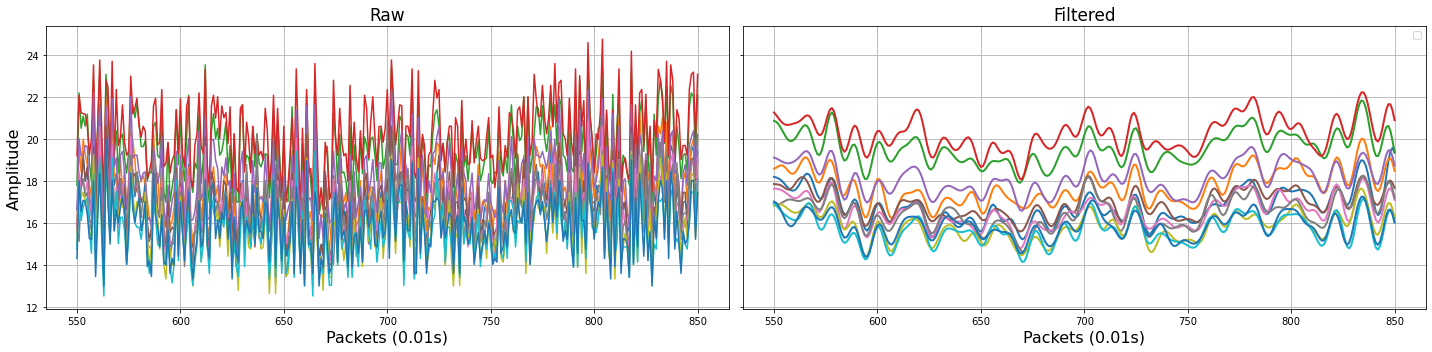

In [48]:
al = 1
step = 5
st_pk = 550

fig, ax = plt.subplots(1, 2, figsize=(20,5), sharey=True)

for i in range(-26,27,step):
    if i == 0:
        continue
    ax[0].plot(amp_raw_p1.loc[st_pk:st_pk+300, f'subc{i}'], alpha = al)
    ax[1].plot(my_utils.butterworth_filter(amp_raw_p1, cutoff_frequency=10).loc[st_pk:st_pk+300, f'subc{i}'], lw=2)
    #ax[2].plot(my_utils.butterworth_filter(amp_raw_p2, cutoff_frequency=10).loc[st_pk:st_pk+300, f'subc{i}'], lw=2)

for axes in ax:
    axes.set_xlabel('Packets (0.01s)', fontsize=16)
    axes.grid(True)

ax[0].set_ylabel('Amplitude', fontsize=16)
ax[0].set_title('Raw', fontsize=17)
ax[1].set_title('Filtered', fontsize=17)
plt.legend()
plt.tight_layout()
plt.show()

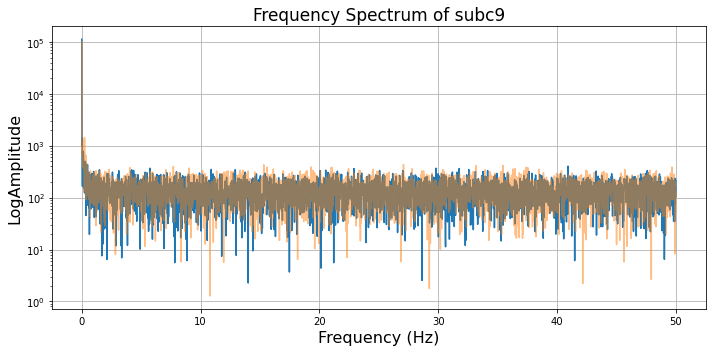

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq

# Extract the signal from the DataFrame
signal =  amp_raw_p1.loc[:6810, 'subc2'].to_numpy()
signal_2 = amp_raw_p2.loc[:6810, 'subc2'].to_numpy()
signal_3 = amp_raw_p3.loc[:6810, 'subc2'].to_numpy()
# Number of samples
N = len(signal)

# Sampling interval (time between samples)
T = 0.01  # Since each packet corresponds to 0.01s

# Compute the Fourier Transform
yf = rfft(signal)
yf_2 = rfft(signal_2)
# Compute the frequency bins
xf = rfftfreq(N, T)

# Plot the frequency spectrum
plt.figure(figsize=(10, 5))
plt.semilogy(xf, np.abs(yf)) # log of abs(yf)
plt.semilogy(xf, np.abs(yf_2), alpha = 0.5)
plt.title('Frequency Spectrum of subc9', fontsize=17)
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.ylabel('LogAmplitude', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


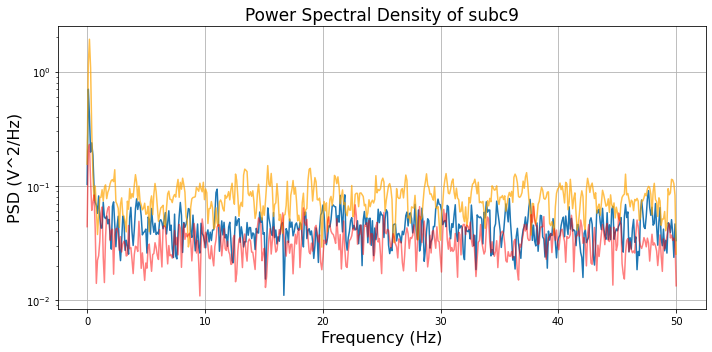

In [148]:
from scipy.signal import welch

f, Pxx = welch(signal, fs=1/T, nperseg=1024)
f2, p2 =  welch(signal_2, fs=1/T, nperseg=1024)
f3, p3 = welch(signal_3, fs=1/T, nperseg=1024)

plt.figure(figsize=(10, 5))
plt.semilogy(f, Pxx) # log of Pxx
plt.semilogy(f2, p2, alpha = 0.7, color = 'orange')
plt.semilogy(f3, p3, alpha = 0.5, color='red')
plt.title('Power Spectral Density of subc9', fontsize=17)
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.ylabel('PSD (V^2/Hz)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
# File paths for amplitude and phase data, grouped by class
amplitude_file_groups = [
    ['andrea1_amp.csv', 'andrea2_amp.csv', 'andrea3_amp.csv', 'andrea4_amp.csv', 'andrea5_amp.csv', 'andrea6_amp.csv'],
    ['gio1_amp.csv', 'gio2_amp.csv', 'gio3_amp.csv', 'gio4_amp.csv', 'gio5_amp.csv', 'gio6_amp.csv'],
    ['jacopo1_amp.csv', 'jacopo2_amp.csv', 'jacopo3_amp.csv', 'jacopo4_amp.csv', 'jacopo5_amp.csv', 'jacopo6_amp.csv'],
    ['katy1_amp.csv', 'katy2_amp.csv', 'katy3_amp.csv', 'katy4_amp.csv', 'katy5_amp.csv', 'katy6_amp.csv'],
    ['laura1_amp.csv', 'laura2_amp.csv', 'laura3_amp.csv', 'laura4_amp.csv', 'laura5_amp.csv', 'laura6_amp.csv', 'laura7_amp.csv', 'lauraDay2_1_amp.csv', 'lauraDay2_2_amp.csv', 'lauraDay2_3_amp.csv', 'lauraDay2_4_amp.csv'],
    ['fra1_amp.csv', 'fra2_amp.csv', 'fra3_amp.csv', 'fra4_amp.csv', 'fra5_amp.csv', 'fra6_amp.csv', 'fra7_amp.csv', 'fra8_amp.csv']
    # Add more groups for other classes
]

phase_file_groups = [
    ['andrea1_phase.csv', 'andrea2_phase.csv', 'andrea3_phase.csv', 'andrea4_phase.csv', 'andrea5_phase.csv', 'andrea6_phase.csv'],
    ['gio1_phase.csv', 'gio2_phase.csv', 'gio3_phase.csv', 'gio4_phase.csv', 'gio5_phase.csv', 'gio6_phase.csv'],
    ['jacopo1_phase.csv', 'jacopo2_phase.csv', 'jacopo3_phase.csv', 'jacopo4_phase.csv', 'jacopo5_phase.csv', 'jacopo6_phase.csv'],
    ['katy1_phase.csv', 'katy2_phase.csv', 'katy3_phase.csv', 'katy4_phase.csv', 'katy5_phase.csv', 'katy6_phase.csv'],
    ['laura1_phase.csv', 'laura2_phase.csv', 'laura3_phase.csv', 'laura4_phase.csv', 'laura5_phase.csv', 'laura6_phase.csv', 'laura7_phase.csv', 'lauraDay2_1_phase.csv', 'lauraDay2_2_phase.csv', 'lauraDay2_3_phase.csv', 'lauraDay2_4_phase.csv'],
    ['fra1_phase.csv', 'fra2_phase.csv', 'fra3_phase.csv', 'fra4_phase.csv', 'fra5_phase.csv', 'fra6_phase.csv', 'fra7_phase.csv', 'fra8_phase.csv']
    # Add more groups for other classes if needed
]

# Create training and test datasets
train_dataset, test_dataset = create_dataset_from_csvs(amplitude_file_groups, phase_file_groups, window_size=100, overlap=50, mean_reduction_ratio=2, train_ratio=0.8)

Class 0: Train points = 1444, Test points = 354
Class 1: Train points = 1448, Test points = 356
Class 2: Train points = 1462, Test points = 359
Class 3: Train points = 1468, Test points = 360
Class 4: Train points = 1553, Test points = 378
Class 5: Train points = 1511, Test points = 369


In [6]:
# store dataset
torch.save(train_dataset, 'train_wifi_dataset_6c.pt')
print("Train data saved")
torch.save(test_dataset, 'test_wifi_dataset_6c.pt')
print("Test data saved")

Train data saved
Test data saved


In [11]:
# Load dataset
test_dataset = torch.load('test_wifi_dataset_6c.pt')

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=32, 
    shuffle=True, 
)

In [12]:
for amp_window, phase_window, labels in test_dataloader:
    print('Train Batch:', amp_window.shape, phase_window.shape, labels.shape)

Train Batch: torch.Size([32, 50, 52]) torch.Size([32, 50, 52]) torch.Size([32])
Train Batch: torch.Size([32, 50, 52]) torch.Size([32, 50, 52]) torch.Size([32])
Train Batch: torch.Size([32, 50, 52]) torch.Size([32, 50, 52]) torch.Size([32])
Train Batch: torch.Size([32, 50, 52]) torch.Size([32, 50, 52]) torch.Size([32])
Train Batch: torch.Size([32, 50, 52]) torch.Size([32, 50, 52]) torch.Size([32])
Train Batch: torch.Size([32, 50, 52]) torch.Size([32, 50, 52]) torch.Size([32])
Train Batch: torch.Size([32, 50, 52]) torch.Size([32, 50, 52]) torch.Size([32])
Train Batch: torch.Size([32, 50, 52]) torch.Size([32, 50, 52]) torch.Size([32])
Train Batch: torch.Size([32, 50, 52]) torch.Size([32, 50, 52]) torch.Size([32])
Train Batch: torch.Size([32, 50, 52]) torch.Size([32, 50, 52]) torch.Size([32])
Train Batch: torch.Size([32, 50, 52]) torch.Size([32, 50, 52]) torch.Size([32])
Train Batch: torch.Size([32, 50, 52]) torch.Size([32, 50, 52]) torch.Size([32])
Train Batch: torch.Size([32, 50, 52]) to